In [1]:
import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
from math import ceil
from pathlib import Path
from matplotlib.colors import LogNorm
import yaml
import time
from waveforms_module.make_waveform import BatchedLightSimulation, mod0_sampler
from tqdm import tqdm, trange

In [2]:
device = torch.device('cuda:0')

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001 # 100 picoseconds, in units of microseconds
	LIGHT_WINDOW: [1, 10]


In [8]:
params = dict()

params['singlet_fraction'] = 0.33
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
params['tau_s'] = 0.001
params['tau_t'] = 1.530
params['tpb_tau'] = 0.002
params['light_gain'] = -45.0
params['light_tick_size'] = 0.001
params['downsample_factor'] = 16

# Check it is updated
sim.reconfigure(params)
print(sim.singlet_fraction)

0.33


In [9]:
times = []
nphotons_arr = np.logspace(4, 8, num=20) 
pmt_ids = torch.arange(128)

for i in range(len(nphotons_arr)):
    nphotons = torch.full_like(pmt_ids, nphotons_arr[i] // 128)
    wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=nphotons, std=1.0) # 0.05 nanoseconds
    start_time = time.time()
    output, info = sim(wf.to(device), combined=True)
    end_time = time.time()
    times.append(end_time - start_time)

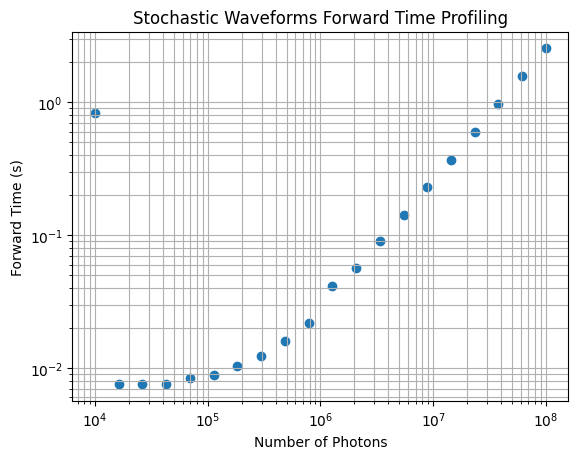

In [16]:
plt.scatter(nphotons_arr, times)
plt.xscale('log')
plt.xlabel("Number of Photons")
plt.ylabel("Forward Time (s)")
plt.title("Stochastic Waveforms Forward Time Profiling")
plt.yscale("log")
plt.grid(which='both')